# Description

New version: Don't do logit difference; take logit directly for the cat.

## Load libraries

In [17]:
import vit_prisma
# import nltk
from nltk.corpus import wordnet as wn
from datasets import load_dataset

from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
import torch

import matplotlib.pyplot as plt

# nltk.download('wordnet')

import numpy as np
from fancy_einsum import einsum

from vit_prisma.utils.data_utils.imagenet_dict import IMAGENET_DICT


## Load dataset

We'll load a downsampled subset of ImageNet-1k.

ImageNet-1k's 1000 classes is the closest thing we'll have to a "dictionary" for this notebook. Note that the dictionary is flexible; e.g. if we were using CLIP, we would have a more expansive dictionary than 1000 classes.

(Optional) Technical note on dataset:
Annoyingly the dataset has two labels: the original ImageNet label, and the dataset's own label. We're using a trimmed down version of the ImageNet that only has a subset of classes. For the purposes of this notebook, I'll try to stick with original ImageNet labels and be explicit when using the dataset labels.

In [2]:
# we'll use a subset of imagenet
dataset = load_dataset("zh-plus/tiny-imagenet")

In [3]:


class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

# Define your transformations, including the custom ConvertTo3Channels
transform = transforms.Compose([
    ConvertTo3Channels(),  # Ensure all images are 3-channel without turning them grayscale
    transforms.Resize((224, 224)),  # Resize images to a common size.
    transforms.ToTensor(),  # Convert images to tensor.
    # You can include normalization if desired, using correct values for 3-channel images.
])

def transform_batch(examples):
    images = [transform(image) for image in examples['image']]
    labels = torch.tensor(examples['label'])
    return {'image': images, 'label': labels}


# Apply transformations to the dataset
dataset.set_transform(transform_batch)

# Create PyTorch DataLoader
batch_size = 2
train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset['valid'], batch_size=batch_size)

# Now, you can use train_loader and valid_loader in your training loop.


In [4]:
# # Catlike things
# n02123045 ['tabby', 'tabby_cat']
# n02123394 ['Persian_cat']
# n02124075 ['Egyptian_cat']
# n02125311 ['cougar', 'puma', 'catamount', 'mountain_lion', 'painter', 'panther', 'Felis_concolor']
# n02129165 ['lion', 'king_of_beasts', 'Panthera_leo']

### Imagenet helper functions

In [5]:
def map_dataset_idx_to_imagenet_idx(subset_index):
    synset = get_wordnet_synset(subset_index)
    word = get_wordnet_name(synset)[0]
    word = word.replace('_', ' ').lower()
    imagenet_index = imagenet_index_from_word(word)
    return imagenet_index

In [6]:
def get_wordnet_synset(index):
    return dataset['train'].features['label'].names[index]

def get_wordnet_name(synset_id):
    # Make sure you have the wordnet data installed


    # Convert the synset ID to a format NLTK understands (remove 'n' and zero-pad)
    offset = int(synset_id[1:])
    wn_id = f"n{str(offset).zfill(8)}"

    # Look up the synset
    synset = wn.synset_from_pos_and_offset('n', offset)

    # Print out the synset's lemma names (the words associated with this synset)
    names = synset.lemma_names()
    return names

def get_wordnet_name_from_dataset_idx(index):
    synset = get_wordnet_synset(index)
    name = get_wordnet_name(synset)
    return name

def get_index_from_synset(synset):
    return dataset['train'].features['label'].names.index(synset)

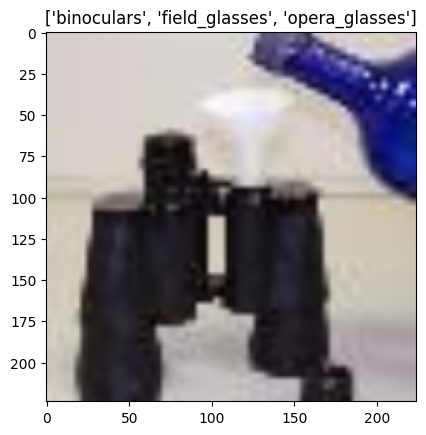

In [7]:
data = next(iter(train_loader))
image, label = data['image'], data['label']

plt.title(get_wordnet_name(get_wordnet_synset(label[1])))
plt.imshow(image[1].permute(1,2,0))



## Load model

In [11]:
import importlib
import vit_prisma
def imagenet_index_from_word(search_term):
    # Convert the search term to lowercase to ensure case-insensitive matching
    search_term = search_term.lower()

    # Iterate over the dictionary and search for the term
    for key, value in IMAGENET_DICT.items():
        if search_term in value.lower():  # Convert each value to lowercase for case-insensitive comparison
            return key  # Return the key directly once found

    # If the loop completes without returning, the term was not found; raise an exception
    raise ValueError(f"'{search_term}' not found in IMAGENET_DICT.")

def imagenet_indices_from_word(search_term, additional_keywords=None):
    # Convert the search term to lowercase to ensure case-insensitive matching
    search_term = search_term.lower()

    # Define additional keywords if not provided
    if additional_keywords is None:
        additional_keywords = ['cat', 'feline', 'kitten']

    # Initialize a list to hold all matching keys
    matching_keys = []

    # Iterate over the dictionary and search for the term
    for key, value in IMAGENET_DICT.items():
        value_lower = value.lower()
        # Check if the search term is present as a whole word in the value
        if search_term in value_lower.split():
            # Further check against additional keywords to filter out false positives
            for keyword in additional_keywords:
                if keyword in value_lower.split():
                    matching_keys.append(key)
                    break  # Stop checking additional keywords once a match is found

    # Check if any matches were found
    if matching_keys:
        return matching_keys  # Return the list of matching keys
    else:
        # If no matches were found, you could return an empty list or raise an exception
        raise ValueError(f"'{search_term}' not found in IMAGENET_DICT or does not match additional criteria.")




In [9]:
# We'll use a vanilla vision transformer
from vit_prisma.models.base_vit import HookedViT
prisma_model = HookedViT.from_pretrained("vit_base_patch32_224", 
                                        center_writing_weights=True, 
                                        center_unembed=True,
                                        fold_ln=True,
                                        refactor_factored_attn_matrices=True,
                                    )

{'n_layers': 12, 'd_model': 768, 'd_head': 64, 'model_name': 'timm/vit_base_patch32_224.augreg_in21k_ft_in1k', 'n_heads': 12, 'd_mlp': 3072, 'activation_name': 'gelu', 'eps': 1e-06, 'original_architecture': 'vit_base_patch32_224', 'initializer_range': 0.02, 'n_channels': 3, 'patch_size': 32, 'image_size': 224, 'n_classes': 1000, 'n_params': 88224232, 'return_type': 'class_logits'}
LayerNorm folded.
Centered weights writing to residual stream
Loaded pretrained model vit_base_patch32_224 into HookedTransformer


In [16]:

def find_cats(data_loader, cat_label, cat_count=6):
    cat_images = []  # List to store images containing cats
    cat_labels = []  # List to store labels of the images (for verification)
    
    count = 0
    for batch in data_loader:
        images, labels = batch['image'], batch['label']
                
        
        # Find indices of images that are labeled as cats
        cat_indices = [index for index, label in enumerate(labels) if label == cat_label]
        
        # Append the cat images and labels to their respective lists
        for index in cat_indices:
            cat_images.append(images[index])

            # Convert dataset label to imagenet label
            imagenet_label = map_dataset_idx_to_imagenet_idx(labels[index])

            cat_labels.append(imagenet_label)
            count += 1
            
            if count >= cat_count:
                break
        
        if count >= cat_count:
            break
    
    return cat_images, cat_labels

# Example usage with the training dataset DataLoader
tabby_syn = 'n02123045'
cat_images_train, cat_labels_train = find_cats(train_loader, cat_label = get_index_from_synset(tabby_syn))

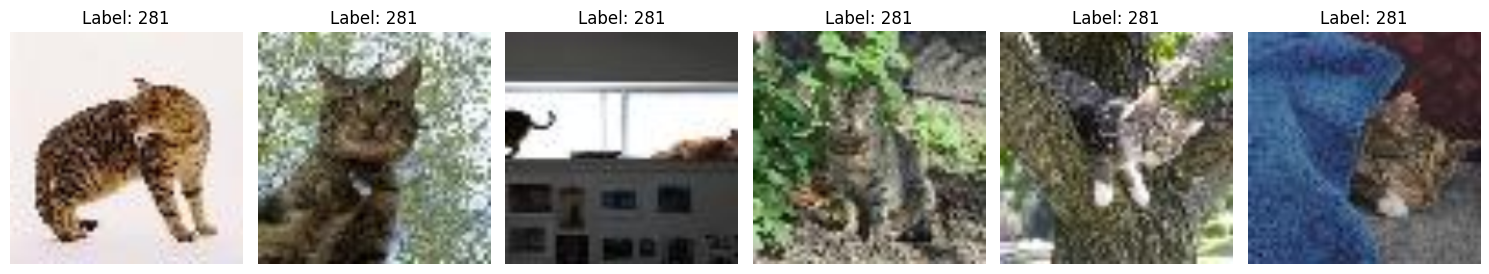

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

def show_image(tensor):
    """
    Converts a tensor to a PIL image and displays it.
    """
    # Convert the tensor to a PIL image using ToPILImage transform
    to_pil_image = T.ToPILImage()
    img = to_pil_image(tensor)
    plt.imshow(img)
    plt.axis('off')  # Don't show axes for images

# Display the first few cat images
fig = plt.figure(figsize=(15, 6))
for i, tensor in enumerate(cat_images_train[:6], start=1):
    ax = fig.add_subplot(1, 6, i)
    show_image(tensor)
    ax.set_title(f"Label: {cat_labels_train[i-1]}")
plt.tight_layout()
plt.show()

In [ ]:
def get_wordnet_synset(index):
    return dataset['train'].features['label'].names[index]

print(dataset['train'].features['label'].names)

['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750', 'n01784675', 'n01882714', 'n01910747', 'n01917289', 'n01944390', 'n01950731', 'n01983481', 'n01984695', 'n02002724', 'n02056570', 'n02058221', 'n02074367', 'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02113799', 'n02123045', 'n02123394', 'n02124075', 'n02125311', 'n02129165', 'n02132136', 'n02165456', 'n02226429', 'n02231487', 'n02233338', 'n02236044', 'n02268443', 'n02279972', 'n02281406', 'n02321529', 'n02364673', 'n02395406', 'n02403003', 'n02410509', 'n02415577', 'n02423022', 'n02437312', 'n02480495', 'n02481823', 'n02486410', 'n02504458', 'n02509815', 'n02666347', 'n02669723', 'n02699494', 'n02769748', 'n02788148', 'n02791270', 'n02793495', 'n02795169', 'n02802426', 'n02808440', 'n02814533', 'n02814860', 'n02815834', 'n02823428', 'n02837789', 'n02841315', 'n02843684', 'n02883205', 'n02892201', 'n02909870', 'n02917067', 'n02927161', 'n02948072'

## Inspect logits

### Print logits

Find the logits for tabby cat

In [18]:

def test_prompt(example_prompt, example_answer, model, top_k=10):

    logits = model(example_prompt.unsqueeze(0)) 
    probs = logits.softmax(dim=-1)
    probs = probs.squeeze(0).detach().numpy()
    sorted_probs = np.sort(probs)[::-1]
    sorted_probs_args = np.argsort(probs)[::-1]

    for i in range(top_k):
        index = sorted_probs_args[i]
        prob = sorted_probs[i]
        logit = logits[0, index].item()  # Assuming you want to show the original logit value
        label = IMAGENET_DICT[index]  # Adjust based on your mapping

        rank_str = f"Top {i}th token."
        logit_str = f"Logit: {logit:.2f}"
        prob_str = f"Prob: {prob * 100:.2f}%"
        token_str = f"Label: |{label}|"

        print(f"{rank_str} {logit_str} {prob_str} {token_str}")


    tabby_cat_idx = imagenet_index_from_word(example_answer)
        
    # Example for displaying ranks of the answer tokens, adjust according to your needs
    answer_index = imagenet_index_from_word(example_answer)
    answer_indices = [answer_index]  # Assuming index is the answer index, adjust as necessary
    print("Rank of the correct answer:")
    for ans_index in answer_indices:
        rank = np.where(sorted_probs_args == ans_index)[0][0]
        print(f"Class Name: {example_answer} | Rank: {rank} | ImageNet Index: {tabby_cat_idx}")

example_prompt = cat_images_train[0]
test_prompt(example_prompt, 'tabby cat', prisma_model)


Top 0th token. Logit: 11.75 Prob: 47.57% Label: |tabby, tabby cat|
Top 1th token. Logit: 11.48 Prob: 36.40% Label: |Egyptian cat|
Top 2th token. Logit: 10.42 Prob: 12.54% Label: |tiger cat|
Top 3th token. Logit: 7.30 Prob: 0.55% Label: |lynx, catamount|
Top 4th token. Logit: 6.84 Prob: 0.35% Label: |screen, CRT screen|
Top 5th token. Logit: 6.36 Prob: 0.22% Label: |Persian cat|
Top 6th token. Logit: 6.15 Prob: 0.18% Label: |space heater|
Top 7th token. Logit: 5.85 Prob: 0.13% Label: |pedestal, plinth, footstall|
Top 8th token. Logit: 5.72 Prob: 0.11% Label: |dishwasher, dish washer, dishwashing machine|
Top 9th token. Logit: 5.17 Prob: 0.07% Label: |photocopier|
Rank of the correct answer:
Class Name: tabby cat | Rank: 0 | ImageNet Index: 281


### Get Logit difference

Things get a bit tricky here. Between tabby cat and non-cat? Between all classes of cats (tabby cats, tiger cats, Egyptian cats, and Persian cats), and non-cats? What about big cats like lynxes and polecats and lions?

A more principled way would be to set a neighborhood of points around the tabby_cat embedding in semantic space and create a tabby cat l-norm ball. However, this is a pending research topic and out of scope for the current demo. So we'll just do tabby cat vs non-tabby cat for now. In the future, we may cluster all the cats together for predictions that are more coarse-grained.

For the non-cat, we'll pick random non-cat objects. We'll avoid cat-like classes for cleanness. This is not necessarily the most principled way of picking a non-cat point in semantic space but good enough for our current purposes.

In [19]:
# Run model and cache activations
cat_images = torch.stack(cat_images_train)
original_logits, cache = prisma_model.run_with_cache(cat_images)

original_logits.shape


torch.Size([6, 1000])

In [20]:
for i, l in zip(cat_images_train, cat_labels_train):
    word_label = IMAGENET_DICT[l]
    test_prompt(i, word_label, prisma_model)
    print('\n')

Top 0th token. Logit: 11.75 Prob: 47.57% Label: |tabby, tabby cat|
Top 1th token. Logit: 11.48 Prob: 36.40% Label: |Egyptian cat|
Top 2th token. Logit: 10.42 Prob: 12.54% Label: |tiger cat|
Top 3th token. Logit: 7.30 Prob: 0.55% Label: |lynx, catamount|
Top 4th token. Logit: 6.84 Prob: 0.35% Label: |screen, CRT screen|
Top 5th token. Logit: 6.36 Prob: 0.22% Label: |Persian cat|
Top 6th token. Logit: 6.15 Prob: 0.18% Label: |space heater|
Top 7th token. Logit: 5.85 Prob: 0.13% Label: |pedestal, plinth, footstall|
Top 8th token. Logit: 5.72 Prob: 0.11% Label: |dishwasher, dish washer, dishwashing machine|
Top 9th token. Logit: 5.17 Prob: 0.07% Label: |photocopier|
Rank of the correct answer:
Class Name: tabby, tabby cat | Rank: 0 | ImageNet Index: 281


Top 0th token. Logit: 8.99 Prob: 41.53% Label: |tabby, tabby cat|
Top 1th token. Logit: 8.79 Prob: 34.20% Label: |Egyptian cat|
Top 2th token. Logit: 7.64 Prob: 10.79% Label: |tiger cat|
Top 3th token. Logit: 5.32 Prob: 1.06% Label: |Pers

I'm thinking randomly picking images doesn't make sense, can actually plot out numbers in semantic space.

Instead, you can create a manifold

You can use the manifold to approximate the semantic space of the net

In [22]:
# def logit_difference(logits, labels, per_prompt=True):

#     answer_logits = logits.gather(dim=-1, index=labels)
#     answer_logit_diff = answer_logits[:,0] - answer_logits[:,1]
#     if per_prompt:
#         return answer_logit_diff.detach()
#     else:
#         return answer_logit_diff.mean()
    
# target_labels = [map_dataset_idx_to_imagenet_idx(int(x)) for x in 

# may need to remap to ImageNet index 
# non_target_labels = [map_dataset_idx_to_imagenet_idx(int(x)) for x in non_cat_labels_train] # may need to remap to ImageNet index 

# paired_labels = [[a, b] for a, b in zip(target_labels, non_target_labels)]
# paired_labels = torch.Tensor(paired_labels).long()


# per_prompt = logit_difference(original_logits, paired_labels)
# print("per prompt:", per_prompt)

# average = logit_difference(original_logits, paired_labels, per_prompt=False)
# print("average:", average.item())

print(cat_labels_train)


# cat_labels = torch.full((6, 1), 281)  # Assuming you want a 6x1 tensor filled with 28s
# You don't want to hardcode this, you want to retrieve 281 correctly.

cat_labels = torch.Tensor(cat_labels_train).long().unsqueeze(0).T
answer_logits = original_logits.gather(dim=-1, index=cat_labels)

average_answer = answer_logits.mean()
print(answer_logits)
print(answer_logits.mean())

[281, 281, 281, 281, 281, 281]
tensor([[11.7505],
        [ 8.9882],
        [ 8.5338],
        [ 2.8261],
        [ 9.2888],
        [ 2.8019]], grad_fn=<GatherBackward0>)
tensor(7.3649, grad_fn=<MeanBackward0>)


## Direct logit attribution

In [23]:
answer_residual_directions = prisma_model.tokens_to_residual_directions(cat_labels_train)
print(answer_residual_directions.shape)

torch.Size([6, 768])


In [24]:
final_residual_stream = cache["resid_post", -1]

# Put 0 to get CLS token at beginning
cls_token_residual_stream = final_residual_stream[:, 0, :]

scaled_final_token_residual_stream = cache.apply_ln_to_stack(cls_token_residual_stream, layer=-1, pos_slice=0 )

print(scaled_final_token_residual_stream.shape)
print(answer_residual_directions.shape)

average_logit = einsum(
    "batch d_model, batch d_model -> batch",
    scaled_final_token_residual_stream,
    answer_residual_directions,
)


# # add bias
# average_logit_diff = average_logit_diff + prisma_model.head.b_H[paired_labels][:,0] - prisma_model.head.b_H[paired_labels][:,1]
# average_logit_diff = average_logit_diff.mean()


average_logit = average_logit + prisma_model.head.b_H[cat_labels][:,0] 
average_logit = average_logit.mean()


print("Calculated average logit diff:", round(average_logit.item(), 3))
print("Original logit difference:", round(average_answer.item(), 3))

torch.Size([6, 768])
torch.Size([6, 768])
Calculated average logit diff: 7.365
Original logit difference: 7.365


## Logit lens

In [25]:
import plotly.express as px

def line(array, **kwargs):
    px.line(
        y=array.detach().cpu().numpy(),
        **kwargs,
    ).show()

In [44]:

# def residual_stack_to_logit_diff(
#     residual_stack,
#     cache
# ) -> float:
#     scaled_residual_stack = cache.apply_ln_to_stack(
#         residual_stack, layer=-1, pos_slice=0
#     )
#     return einsum(
#         "... batch d_model, batch d_model -> ...",
#         scaled_residual_stack,
#         logit_diff_directions,
#     ) / len(cat_images)



def residual_stack_to_logit(
    residual_stack,
    cache
):

    scaled_residual_stack = cache.apply_ln_to_stack(
            accumulated_residual, layer=-1, pos_slice=0
        )


    logit_predictions = einsum(
        "layer batch d_model, batch d_model -> batch layer",
        scaled_residual_stack,
        answer_residual_directions,
    )
    return logit_predictions


accumulated_residual, labels = cache.accumulated_resid(
        layer=-1, incl_mid=True, pos_slice=0, return_labels=True
        
    )
logit_predictions = residual_stack_to_logit(accumulated_residual, cache)

print(logit_predictions.shape)
logit_predictions = logit_predictions.T + prisma_model.head.b_H[cat_labels][:,0] # Add bias to ensure matching results above
average_logit = logit_predictions.mean(-1).T

line(average_logit, labels=labels, hover_name=labels, title="Logits through residual stream")

torch.Size([6, 25])


In [27]:


def get_all_logit_values(
    residual_stack,
    cache,
    all_answers,
) -> float:
    scaled_residual_stack = cache.apply_ln_to_stack(
        residual_stack, layer=-1, pos_slice=0
    )

    # # print shapes
    # print(scaled_residual_stack.shape)
    # print(answer_residual_directions.shape)
    

    result = torch.einsum('ijk,lk->ijl', scaled_residual_stack, all_answers)
    return result


accumulated_residual, labels = cache.accumulated_resid(
    layer=-1, incl_mid=True, pos_slice=0, return_labels=True
)

all_answers = prisma_model.tokens_to_residual_directions(np.arange(1000))
predictions = get_all_logit_values(accumulated_residual, cache, all_answers)

top_k = 5
batch_idx = 1

rank_list = []
top_of_multiple = []
for layer_idx, logits in enumerate(predictions[:,batch_idx,:]):

    print(logits.shape)

    probs = logits.softmax(dim=-1)
    probs = probs.squeeze(0).detach().numpy()
    sorted_probs = np.sort(probs)[::-1]
    sorted_probs_args = np.argsort(probs)[::-1]

    print("Layer", layer_idx)
    for i in range(top_k):
        index = sorted_probs_args[i]
        prob = sorted_probs[i]
        logit = logits[index].item()  # Assuming you want to show the original logit value
        label = IMAGENET_DICT[index]  # Adjust based on your mapping

        logit_str = f"Logit: {logit:.2f}"
        prob_str = f"Prob: {prob * 100:.2f}%"
        token_str = f"Label: |{label}|"

        print(f"{logit_str} {prob_str} {token_str}")
    

    answer_index = imagenet_index_from_word("tabby cat")
    answer_indices = [answer_index]  # Assuming index is the answer index, adjust as necessary
    # print("Rank of the correct answer:")
    for ans_index in answer_indices:
        rank = np.where(sorted_probs_args == ans_index)[0][0]
    
    print(f"Class Name: {'tabby cat'} | Rank: {rank} | ImageNet Index: {answer_index}")
    rank_list.append(rank)

    multiple_ranks = []
    multiple_indices = imagenet_indices_from_word("cat")[:-1]

    print("Indices:", multiple_indices)
    print("Words:", [IMAGENET_DICT[i] for i in multiple_indices])
    for ans_index in multiple_indices:
        rank = np.where(sorted_probs_args == ans_index)[0][0]
        print(f"Class Name: {'cat'} | Rank: {rank} | ImageNet Index: {ans_index}")
        multiple_ranks.append(rank)

    # Top rank of multiple ranks
    print("Top rank of multiple ranks:", min(multiple_ranks))
    top_of_multiple.append(min(multiple_ranks))

    print()
# line(logit_lens_logit_diffs, labels=labels, title="Logit length logit diffs")
    


torch.Size([1000])
Layer 0
Logit: 1.95 Prob: 0.62% Label: |chainlink fence|
Logit: 1.88 Prob: 0.58% Label: |ping-pong ball|
Logit: 1.52 Prob: 0.40% Label: |potpie|
Logit: 1.47 Prob: 0.38% Label: |cloak|
Logit: 1.44 Prob: 0.37% Label: |whistle|
Class Name: tabby cat | Rank: 793 | ImageNet Index: 281
Indices: [281, 282, 283, 285]
Words: ['tabby, tabby cat', 'tiger cat', 'Persian cat', 'Egyptian cat']
Class Name: cat | Rank: 793 | ImageNet Index: 281
Class Name: cat | Rank: 792 | ImageNet Index: 282
Class Name: cat | Rank: 751 | ImageNet Index: 283
Class Name: cat | Rank: 744 | ImageNet Index: 285
Top rank of multiple ranks: 744

torch.Size([1000])
Layer 1
Logit: 2.15 Prob: 0.72% Label: |ping-pong ball|
Logit: 2.02 Prob: 0.63% Label: |chainlink fence|
Logit: 1.84 Prob: 0.53% Label: |potpie|
Logit: 1.78 Prob: 0.50% Label: |pop bottle, soda bottle|
Logit: 1.76 Prob: 0.49% Label: |cloak|
Class Name: tabby cat | Rank: 946 | ImageNet Index: 281
Indices: [281, 282, 283, 285]
Words: ['tabby, tab

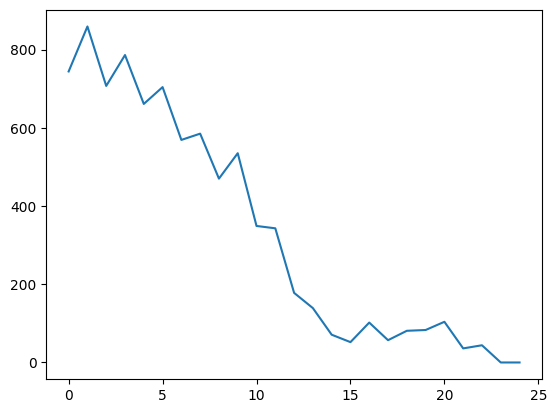

In [28]:
plt.figure()
plt.plot(top_of_multiple)

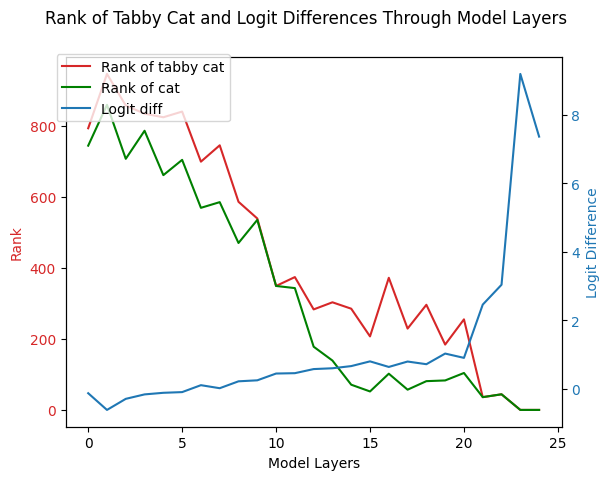

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import torch  # Assuming logit_lens_logit_diffs is a torch tensor
# Create figure and axis
fig, ax1 = plt.subplots()

# Plot ranks on the first axis
color = 'tab:red'
ax1.set_xlabel('Model Layers')
ax1.set_ylabel('Rank', color=color)
ax1.plot(rank_list, color=color, label='Rank of tabby cat')
ax1.tick_params(axis='y', labelcolor=color)

ax1.plot(top_of_multiple, color='green', label='Rank of cat')

# Create a second y-axis for the logit differences
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Logit Difference', color=color)
ax2.plot(average_logit.detach().numpy(), color=color, label='Logit diff')
ax2.tick_params(axis='y', labelcolor=color)



# Title and legend
fig.suptitle('Rank of Tabby Cat and Logit Differences Through Model Layers')
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))

plt.show()


In [31]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming rank_list and logit_lens_logit_diffs are defined
# Convert logit_lens_logit_diffs to a NumPy array if it's a torch tensor
logit_diffs_np = average_logit.detach().numpy()

# Create a figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add rank plot
fig.add_trace(
    go.Scatter(x=list(range(len(rank_list))), y=rank_list, name="Rank of tabby cat", mode='lines+markers'),
    secondary_y=False,
)

# Add top of multiple
fig.add_trace(
    go.Scatter(x=list(range(len(top_of_multiple))), y=top_of_multiple, name="Rank of cat", mode='lines+markers'),
    secondary_y=False,
)

# Add logit difference plot
fig.add_trace(
    go.Scatter(x=list(range(len(logit_diffs_np))), y=logit_diffs_np, name="Logit diff", mode='lines+markers'),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Rank of Tabby Cat and Logit Differences Through Model Layers"
)

# Set x-axis title
fig.update_xaxes(title_text="Model Layers")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Rank</b> of tabby cat", secondary_y=False)
fig.update_yaxes(title_text="<b>Logit Difference</b>", secondary_y=True)

fig.show()


## Layer attribution

In [49]:
per_layer_residual = cache.decompose_resid(
    layer=-1, pos_slice=0, return_labels=False
)

print(per_layer_residual.shape)

per_layer_logit_diffs = residual_stack_to_logit(per_layer_residual.detach().numpy(), cache)
line(per_layer_logit_diffs)

torch.Size([26, 6, 768])


ValueError: could not convert string to float: 'wide_variable_0'

## Head attribution

In [66]:
def residual_stack_to_logit_attn(
    residual_stack,
    cache
) -> float:
    scaled_residual_stack = cache.apply_ln_to_stack(
        residual_stack, layer=-1, pos_slice=0
    )
    return einsum(
        "... batch d_model, batch d_model -> ...",
        scaled_residual_stack,
        answer_residual_directions,
    ) / len(cat_images)

In [68]:
import einops
per_head_residual, labels = cache.stack_head_results(
    layer=-1, pos_slice=0, return_labels=True
)

per_head_logit_diffs = residual_stack_to_logit_attn(per_head_residual, cache)

per_head_logit_diffs = einops.rearrange(
    per_head_logit_diffs,
    "(layer head_index) -> layer head_index",
    layer=prisma_model.cfg.n_layers,
    head_index=prisma_model.cfg.n_heads,
)
px.imshow(
    per_head_logit_diffs.detach().cpu().numpy(),
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head",
)

## Attention analysis

Empirically, the attention scores are more interpretable than the attention patterns (unlike language, where patterns tend to be visualized). We'll focus on visualizing the attention scores.

In [69]:
def visualize_attention_patterns(
    heads,
    local_cache,
    # local_tokens,
    title,
    max_width,
    batch_idx
) -> str:
    # If a single head is given, convert to a list
    if isinstance(heads, int):
        heads = [heads]

    # Create the plotting data
    labels: List[str] = []
    patterns: List[Float[torch.Tensor, "dest_pos src_pos"]] = []


    for head in heads:
        # Set the label
        layer = head // prisma_model.cfg.n_heads
        head_index = head % prisma_model.cfg.n_heads
        labels.append(f"L{layer}H{head_index}")

        # Get the attention patterns for the head
        # Attention patterns have shape [batch, head_index, query_pos, key_pos]
        patterns.append(local_cache["attn", layer][batch_idx, head_index])

    # # Convert the tokens to strings (for the axis labels)
    # str_tokens = model.to_str_tokens(local_tokens)

    # Combine the patterns into a single tensor
    patterns = torch.stack(
        patterns, dim=0
    )
    print(patterns.shape)
    return patterns

def visualize_attention_scores(
    heads,
    local_cache,
    # local_tokens,
    title,
    max_width,
    batch_idx
) -> str:
    # If a single head is given, convert to a list
    if isinstance(heads, int):
        heads = [heads]

    # Create the plotting data
    labels: List[str] = []
    patterns: List[Float[torch.Tensor, "dest_pos src_pos"]] = []


    for head in heads:
        # Set the label
        layer = head // prisma_model.cfg.n_heads
        head_index = head % prisma_model.cfg.n_heads
        labels.append(f"L{layer}H{head_index}")

        # Get the attention patterns for the head
        # Attention patterns have shape [batch, head_index, query_pos, key_pos]
        patterns.append(local_cache["attn_scores", layer][batch_idx, head_index])

    # # Convert the tokens to strings (for the axis labels)
    # str_tokens = model.to_str_tokens(local_tokens)

    # Combine the patterns into a single tensor
    patterns = torch.stack(
        patterns, dim=0
    )
    print(patterns.shape)
    return patterns

In [71]:
top_k = 3
top_positive_logit_attr_heads = torch.topk(
    per_head_logit_diffs.flatten(), k=top_k
).indices

print(top_positive_logit_attr_heads)

batch_idx = 0
patterns = visualize_attention_patterns(top_positive_logit_attr_heads, cache, "test", 700, batch_idx = batch_idx)


tensor([136, 143, 137])
torch.Size([3, 50, 50])


In [73]:
list_of_images = [cat_images[batch_idx], cat_images[batch_idx], cat_images[batch_idx]]

print(len(patterns))
print

3


<function print>

In [74]:
import importlib

# First, ensure you have imported the module at least once
import vit_prisma.visualization.visualize_attention_js

# Reload the module
importlib.reload(vit_prisma.visualization.visualize_attention_js)

# Now, import the specific function you need
from vit_prisma.visualization.visualize_attention_js import plot_javascript


In [75]:
from vit_prisma.visualization.visualize_attention_js import plot_javascript
patterns = visualize_attention_patterns(top_positive_logit_attr_heads, cache, "test", 700, batch_idx = batch_idx)

html_code = plot_javascript(patterns, list_of_images, ATTN_SCALING=8)

# import
from IPython.display import HTML, display


display(HTML(html_code))

torch.Size([3, 50, 50])


In [76]:
# import
from IPython.display import HTML, display
patterns = visualize_attention_scores(top_positive_logit_attr_heads, cache, "test", 700, batch_idx = batch_idx)

html_code = plot_javascript(patterns, list_of_images, ATTN_SCALING=8)

display(HTML(html_code))

torch.Size([3, 50, 50])


Is the 44th patch token also a register token? This is also the 44 idx (includign CLS token).

We should ablate the 44th token and see the effect on logits. Or we could just feed all the tokens into the logit head for tabby cats and see which has the highest logit score.

In [81]:
all_answers.shape

torch.Size([1000, 768])

In [98]:


def residual_stack_to_logit_diff(
    residual_stack,
    cache,
    pos_slice
) -> float:
    scaled_residual_stack = cache.apply_ln_to_stack(
        residual_stack, layer=-1, pos_slice=pos_slice
    )

    # # print shapes
    # print(scaled_residual_stack.shape)
    # print(answer_residual_directions.shape)

    result = torch.einsum('ijk,lk->ijl', scaled_residual_stack, all_answers)
    return result


patch_ranks = np.empty((50, 25))
patch_logits = np.empty((50, 25))

for pos_slice in range(50):
    patch_info = []

    accumulated_residual, labels = cache.accumulated_resid(
        layer=-1, incl_mid=True, pos_slice=pos_slice, return_labels=True
    )

    predictions = residual_stack_to_logit_diff(accumulated_residual, cache, pos_slice=pos_slice)
    print(predictions.shape)

    top_k = 5
    batch_idx = 1

    rank_list = []
    top_of_multiple = []
    for layer_idx, logits in enumerate(predictions[:,batch_idx,:]):

        probs = logits.softmax(dim=-1)
        probs = probs.squeeze(0).detach().numpy()
        sorted_probs = np.sort(probs)[::-1]
        sorted_probs_args = np.argsort(probs)[::-1]

        print("Layer", layer_idx)
        for i in range(top_k):
            index = sorted_probs_args[i]
            prob = sorted_probs[i]
            logit = logits[index].item()  # Assuming you want to show the original logit value
            label = IMAGENET_DICT[index]  # Adjust based on your mapping

            logit_str = f"Logit: {logit:.2f}"
            prob_str = f"Prob: {prob * 100:.2f}%"
            token_str = f"Label: |{label}|"

            # print(f"{rank_str} {logit_str} {prob_str} {token_str}")
        

        answer_index = imagenet_index_from_word("tabby cat")
        answer_indices = [answer_index]  # Assuming index is the answer index, adjust as necessary
        # print("Rank of the correct answer:")
        for ans_index in answer_indices:
            rank = np.where(sorted_probs_args == ans_index)[0][0]
            logit = logits[ans_index].item()
        
        print(f"Class Name: {'tabby cat'} | Rank: {rank} | ImageNet Index: {answer_index}")
        rank_list.append(rank)

        patch_ranks[pos_slice, layer_idx] = rank




torch.Size([25, 6, 1000])
Layer 0
Class Name: tabby cat | Rank: 793 | ImageNet Index: 281
Layer 1
Class Name: tabby cat | Rank: 946 | ImageNet Index: 281
Layer 2
Class Name: tabby cat | Rank: 857 | ImageNet Index: 281
Layer 3
Class Name: tabby cat | Rank: 834 | ImageNet Index: 281
Layer 4
Class Name: tabby cat | Rank: 824 | ImageNet Index: 281
Layer 5
Class Name: tabby cat | Rank: 840 | ImageNet Index: 281
Layer 6
Class Name: tabby cat | Rank: 699 | ImageNet Index: 281
Layer 7
Class Name: tabby cat | Rank: 745 | ImageNet Index: 281
Layer 8
Class Name: tabby cat | Rank: 586 | ImageNet Index: 281
Layer 9
Class Name: tabby cat | Rank: 539 | ImageNet Index: 281
Layer 10
Class Name: tabby cat | Rank: 349 | ImageNet Index: 281
Layer 11
Class Name: tabby cat | Rank: 374 | ImageNet Index: 281
Layer 12
Class Name: tabby cat | Rank: 283 | ImageNet Index: 281
Layer 13
Class Name: tabby cat | Rank: 303 | ImageNet Index: 281
Layer 14
Class Name: tabby cat | Rank: 285 | ImageNet Index: 281
Layer 15


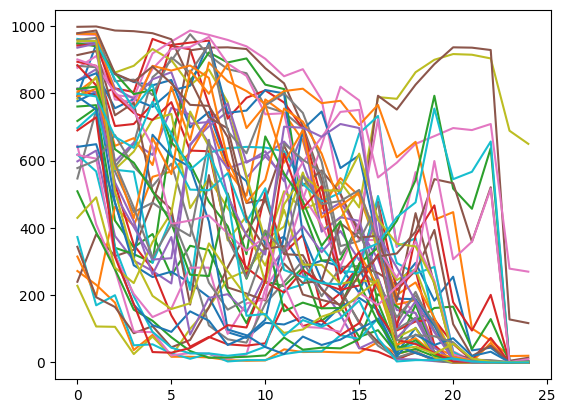

In [101]:
plt.figure()
plt.plot(patch_ranks.T)

In [91]:
total_patch_logits

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

## Activation patching

Maybe I can activation patch with the ear?

## Residual stream

## Layers

## Heads

## Decomposing heads

## Consolidating understanding

## Random fun things